# l-1 trend filtering 

В своей знаменитой статье [l-1 trend filtering](https://web.stanford.edu/~boyd/papers/l1_trend_filter.html) Стивен Бойд и его коллеги предложили подход к выявлению тренда в финансовых временных рядах с помощью выпуклой оптимизации. В частности, вместо построения стохастической модели временного ряда, они предложили отталкиваться от задачи - построить кусочно-линейную линию тренда, наилучшим образом аппроксимирующую данный временной ряд.

Это привело к задачи оптимизации следующего вида:

**TrendFilter problem**
$$
\min_{x \in R^T} \frac{1}{2}\|y - x\|_2^2 + \lambda \|Dx\|_1
$$
где $y \in R^T$ - временной ряд фактических цен акции (с момента времени $t = 1$ до момента времени $T$), матрица $D \in R^{(T-2) \times T}$ является трехдиагональной: $[Dx]_i = x_i - 2 \cdot x_{i+1} + x_{i+2} \quad$ ($1\leq i \leq T-2$).

Первый член в целевой функции отвечает за близость решения к фактическим данным, а второй форсирует решение  быть кусочно-линейной функцией с минимальным числом "изломов". 

Задание:
1.   Скачайте тестовые данные: данные о цене закрытия акций российских финансовых компаний (например, с finam.ru). Это ваши тестовые данные. 
2.   Выпишите двойственную задачу для задачи Trend Filter.
3.   Численно решите задачу Trend Filter используя одну из версий проксимального градиентного спуска.
4.   Выпишите сглаженную версию задачи Trend Filter и найдите ее решение используя метод быстрого градиентного спуска (версия из лекции про сглаживание).
6.   Сравните скорость сходимости методов.

# Двойственная задача
Введем фиктивное ограничение $z = Dx$. Функция Лагранжа примет вид:
$$
L(x, z, \mu) = 0.5 \|y-x\|_2^2 + \lambda\|z\|_1 + \mu^T(z - Dx) = 
0.5\|x - y\|_2^2 - c^T x + \lambda\|z\|_1 + \mu^T z
$$Здесь мы обозначили $c = D^T\mu$
Выделим полный квадрат:
$$
L(x, z, \mu) = 0.5 \|x - y - c\|_2^2 - 0.5\|c\|_2^2 - c^T y + \lambda\|z\|_1 + \mu^T z
$$Двойственная функция имеет вид:
$$
g(\mu) =  - 0.5\|D^T\mu\|_2^2 - \mu^T D y
$$Инфинум первого слагаемого по $x$ очивиден, он достигается при $x = y + c$. Во втором слагаемом выделяется сопряженная функция к первой норме, она равна нулю, если $\|\mu\|_{\infty} \leq \lambda$, иначе бесконечность. Таким образом, сопряженная задача ставиться как:
$$
\begin{align}
&\underset{\mu}{\min} 0.5\|D^T\mu\|_2^2 + \mu^T D y\\
&s.t.\;\|\mu\|_{\infty} \leq \lambda
\end{align}
$$

# Проксимальный градиент
Нужно решить задачу 
$$
x_{k+1} = \underset{z}{\arg\min} \dfrac{\mu}{2} \|z - v\|_2^2 + \lambda \|Dz\|_1
$$
Она совпадает с исходной, так что не совсем понятно, как её решать. Поэтому я буду решать проксимальным градиентом двойственную задачу. Для ней все очевидно, сама целевая функция гладкая, негладкость берется из ограничений. Но и там тоже все просто, так как проецкия на множество $\{\mu|-\lambda \leq \mu_i \leq \lambda\}$ тривиальна (np.clip(mu, -lam, lam)). 

В сопряженной задаче градиент считается как:
$$
\nabla g = \nabla \left( 0.5 \|D^T\mu\|_2^2 + \mu^T Dy  \right) = Dy + DD^T\mu
$$Нетрудно показать, что у матрицы $DD^T$ максимальное собственное значение будет стремится к $16$ при росте порядка матрицы. Его мы и будем брать в качестве оценки $L$.

# Быстрый градиентный метод
Сгладим каждый модуль, т.е. заменим его на функцию Хьюбера:
$$
h_{t}^0(z) =  \begin{align}\begin{cases}\dfrac{z^2}{2t}, &|z| \leq t \\ 
    |z| - \dfrac{t}{2}, &|z| \geq t
\end{cases}\end{align}
$$где $z = Dx$. Тогда $\widetilde{h}(z) = \sum_{i=1}^{T-2}h_t^{0}(z)$. Вычислим градиент по $z:$
$$
\nabla_{z_i} \widetilde{h}(z) =\lambda \begin{align}\begin{cases} 
    \dfrac{z^i}{t}, &|z^i| \leq t \\
    \mathrm{sign}(z^i), &|z^i| \geq t
\end{cases} \end{align}
$$Чтобы вычислить производную от $x$, достаточно домножить это на $D^T$(производная сложной функции), т.е. получим:
$$
\nabla_{x} \widetilde{h}(Dx) = D^T \nabla_{z} \widetilde{h}(z)
$$

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from numba import jit
from tqdm import tqdm

D:\Programs\Anaconda\lib\site-packages\llvmlite\binding\llvmlite.dll


In [2]:
data = pd.read_csv("data.txt")#скачиваем данные, катировки Газпрома
data.head(3)

,<TICKER>,<PER>,<DATE>,<TIME>,<LAST>,<VOL>
0,GAZP,0,20210517,95939,250.0,40
1,GAZP,0,20210517,95939,250.0,10
2,GAZP,0,20210517,95939,250.0,30


In [18]:
y = data["<LAST>"].values

In [19]:
def D2(y):#вротая производная
    return y[:-2] - 2 * y[1:-1] + y[2:]

@jit
def D2T(w):#D^T
    n = len(w) + 2
    res = np.zeros((n, 1))
    res[0] = w[0]
    res[1] = -2 * w[0] + w[1]
    for i in range(2, n-2):
        res[i] = w[i-2]-2*w[i-1]+w[i]
    res[n-2] = w[n-4]-2*w[n-3]
    res[n-1] = w[n-3]
    return res.reshape(-1)


@jit
def huber_grad(x_range, t):#функция хуберта + градиент
    h = np.zeros_like(x_range)
    grad = np.zeros_like(x_range)
    for i, x in enumerate(x_range):
        if np.abs(x) <= t:
            h[i] = x**2 / (2 * t)
            grad[i] = x / t
        else:
            h[i] = np.abs(x) - t / 2
            grad[i] = np.sign(x)
    return h, grad


@jit
def foo_grad(x, y):#градиент гладкой части
    f = 0.5 * np.linalg.norm(x-y)**2
    grad = x-y
    return f, grad


def FastGrad(y, n_iter, lam, t=1):#у меня получилось, что метод очень 
                                   #неустойчив по отношению к параметрам, 
                                   #поэтому я взял достаточно малый шаг
    mu = 10000
    n = y.shape[0]
    x = y.copy()#инициализация весов
    z = x.copy()
    fs = [0] * n_iter
    grad_norm = [0] * n_iter
    for i in tqdm(range(n_iter)):
        h, h_grad = huber_grad(D2(x), t)#вычисляем градиент негладкого слагаемого
        grad = (x - y) + lam * D2T(h_grad)#вычисляем полный градиент
        fs[i] = 0.5 * np.linalg.norm(x-y)**2 + lam * np.linalg.norm(D2(x), 1)
        #вычисляем полное значение целевой функции(для графика)
        #здесь я вычисляю именно исходную функцию, а не сглаженную, чтобы можно было сравнивать разные методы
        grad_norm[i] = np.linalg.norm(grad)#вычисляем норму градиента(для графика)
        #шаг ускоренного градиентного спуска
        x_new = x - grad / mu
        z = x_new + i / (i + 3) * (x_new - x)
        x = x_new
        
    return x, fs, grad_norm


def DualGrad(y, n_iter, lam):#тут решаем двойственную задачу. там тоже ищем минимум
    L = 16
    n = y.shape[0]
    mu = np.zeros((n-2, 1)).reshape(-1)#инициализация весов
    fs = [0] * n_iter
    grad_norm = [0] * n_iter
    for i in tqdm(range(n_iter)):
        #x = y + D^T(mu)
        #grad = D( y + D^T(mu) ) = Dx
        grad = D2(y + D2T(mu))
        fs[i] = 0.5 * np.linalg.norm(D2T(mu))**2 + lam * np.linalg.norm(grad, 1)
        grad_norm[i] = np.linalg.norm(grad)#вычисляем норму градиента(для графика)
        #шаг градиентного спуска
        mu = mu - grad / (2.0 * L)
        #прокс отображение
        mu = np.clip(mu, -lam, lam)
        
    return y + D2T(mu), fs, grad_norm

In [20]:
n_iter = 2000
#возьмем достаточно большой  параметр регуляризации, чтобы видно было сглаживание
lam = 200

In [21]:
x, fs, grad_norm = FastGrad(y, n_iter, lam)

100%|█████████████████████████████████████| 2000/2000 [00:09<00:00, 220.86it/s]


In [22]:
xd, fsd, grad_normd = DualGrad(y, n_iter, lam)

100%|█████████████████████████████████████| 2000/2000 [00:08<00:00, 237.71it/s]


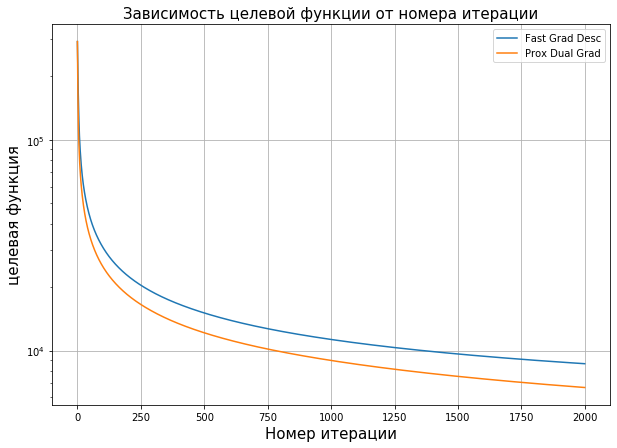

In [23]:
niter = np.arange(len(fs))
plt.figure(figsize=(10, 7))
plt.semilogy(niter, fs, label="Fast Grad Desc")
plt.semilogy(niter, fsd, label="Prox Dual Grad")
plt.grid()
plt.title("Зависимость целевой функции от номера итерации", fontsize=15)
plt.xlabel("Номер итерации", fontsize=15)
plt.ylabel("целевая функция", fontsize=15)
plt.legend()
None

По графику видно, что проксимальный метод для двойственной задачи сходится быстрее. Это скорее всего связанно с тем, что в быстром градиентном спуске я брал слишком маленький шаг. Его можно менять, если увеличить шаг, то быстрый градиент будет быстрее, однако при слишком большом шаге он начинает расходится.

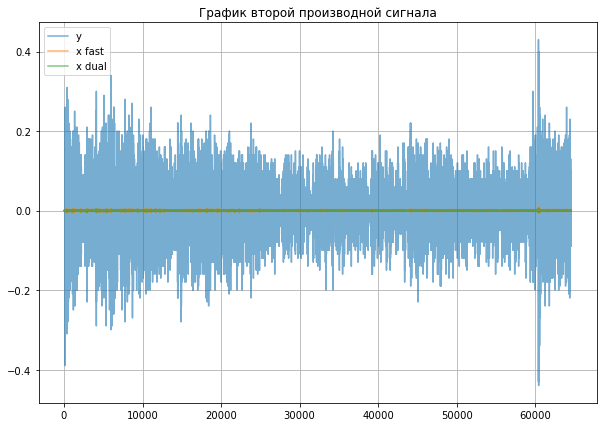

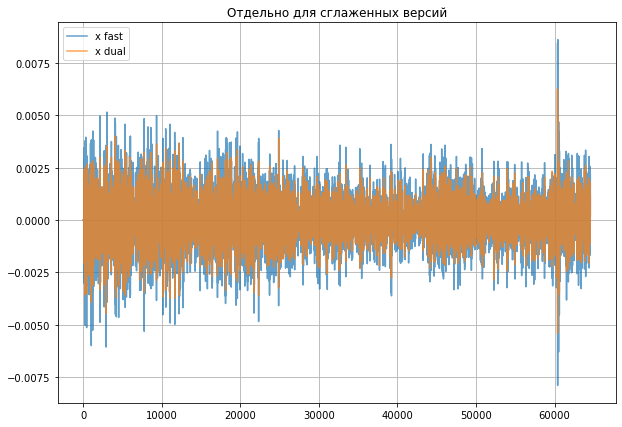

In [195]:
plt.figure(figsize=(10, 7))
plt.plot(D2(y), alpha=0.6, label='y')
plt.plot(D2(x), alpha=0.6, label='x fast')
plt.plot(D2(xd), alpha=0.6, label='x dual')
plt.title('График второй производной сигнала')
plt.legend()
plt.grid()
None
plt.figure(figsize=(10, 7))
plt.plot(D2(x), alpha=0.7, label='x fast')
plt.plot(D2(xd), alpha=0.7, label='x dual')
plt.title('Отдельно для сглаженных версий')
plt.legend()
plt.grid()
None

Видно, что у сигналов, полученных после оптимизации, вторая производная намного меньше, чем у исходного сигнала, т.е. регуляризация сработала. Так как длина сигнала очень большая, я не вижу рисовать сами графики $y, x$, так как там ничего не будет заметно. Графики будут просто накладываться друг на друга, так как невязка $\|y-x\|_2^2$ не смотря на регуляризацию все равно достаточно мала.

Какой вывод можно сделать? Судя по графику, скорость сходимости обоих методов близка друг к другу. Однако мне кажется, что решение прямой задачи более чувствительно к параметрам алгоритма (к длине шага и параметру сглаживания). В дуальной задаче параметров меньше + есть аналитическая оценка на константу Липшица. Возможно, если использовать быстрые проксимальные град. спуски, его ещё можно ускорить.

# Бинарная классификация 



Решается задача бинарной классификации.
Для этого используется классификатор на базе l1-регуляризованной логистической регрессии. 

Чтобы "обучить" модель нужно решить задачу оптимизации:
$$
\min_{w\in R^n}  \sum_{i=1}^l \log (1+\exp(-y_i w^Tx_i)) + \lambda \|w\|_1
$$

В этом задании Вам нужно протестировать методы, которые мы прошли в этом семестре:
*   Проведите расчеты для данных a8a и criteo (https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html) 
*   Сравните скорость сходимости методов для этого инстанса задачи (то есть конкретно для этого набора данных)

Вы изучили достаточно много методов для решения таких задач:

*   Постройте двойственную задачу и решите ее численно используя метод проксимального градиентного спуска (5 баллов).
*   Реализуйте метод ADMM для этой задачи (3 балла)
*   Реализуйте быстрый градиентный спуск используя метод сглаживания (5 баллов)
*   Реализуйте метод субградиентного спуска для этой задачи (3 балла)
*   Выберите и реализуйте рандомизированные методы первого порядка для решения этой задачи, выбор обоснуйте.
















## Проксимальный градиентный спуск:

У нас функция $L(w) = f(w) + h(w)$, где 
$$
f(w) = \sum_{i=1}^l \log (1+\exp(-y_i w^Tx_i))
$$
$$
h(w) = \lambda \|w\|_1
$$Градиент гладкой части равен:
$$
\nabla f(w) = -\sum_{i=1}^l \dfrac{y_ix_i\exp(-y_i w^Tx_i)}{1+\exp(-y_i w^Tx_i)} = 
-\sum_{i=1}^l \dfrac{y_ix_i}{1+\exp(y_i w^Tx_i)} 
$$Точка обновляется по следующему правилу:
$$
w_{k+1} =  \underset{y \in R^n}{\arg\min} \left( h(y) + \dfrac{\mu}{2} \|y - v\|_2^2  \right) = 
 \underset{y \in R^n}{\arg\min} \left( \lambda \|y\|_1 + \dfrac{\mu}{2} \|y - v\|_2^2  \right)
$$
где $v = w_{k} - \dfrac{1}{\mu}\nabla f(w_{k})$, $\mu$ - отвечает за шаг $\alpha = \dfrac{1}{\mu}$

Для $L_1$ регуляризации прокс. отображение находится аналитически:
$$
w_{k+1}^i = 
\begin{align}
\begin{cases}
    v^i - \dfrac{\lambda}{\mu}, \; &v^i > \dfrac{\lambda}{\mu} \\
    v^i + \dfrac{\lambda}{\mu}, \; &v^i < -\dfrac{\lambda}{\mu}\\
    0, \; &v^i \in [-\dfrac{\lambda}{\mu}, \dfrac{\lambda}{\mu}]
\end{cases} 
\end{align}
$$

# Двойственная задача

$$
\begin{align}
&\underset{w \in R^n, z\in R^l}{\min} \sum_{i=1}^l \log(1+\exp(-z_i) ) + \lambda \|w\|_1 \\
&s.t. \; z = Xw
\end{align}
$$где $X = Y \tilde{X}$, где $Y = \mathrm{diag}(y)$, $\tilde{X}$ -- матрица данных.
Лагранжиан:
$$
L(z, w, \mu) = \sum_{i=1}^l \log(1+\exp(-z_i) ) + \lambda \|w\|_1 + \mu^T(z - Xw) = 
\sum_{i=1}^l (\log(1+\exp(-z_i) )+z_i\mu_i) + \lambda \|w\|_1 - (\mu^T X) w 
$$

 $\inf$ второго слагаемого:
 $$
 \inf \lambda \|w\|_1 - (X^T \mu)^T w = -\lambda \left( \sup c^T w -  \|w\|_1 \right)
 $$где $c = \dfrac{1}{\lambda} X^T\mu$
 Обозначим функцию под $\sup$ за $F(w)$. В скобках стоит сопряженная функция к $L_1$ норме,т.е.
 $$
 F^*(с) = \mathbb{I}(\|c\|_{\infty} \leq 1)
 $$Таким образом, $F^*(c) = 0$ для допустимых значений + появляется ограничение $\|X^T\mu\|_{\infty} \leq \lambda$

Рассмотрим отдельное слагаемое в первой сумме. 
$$
F(z) = \log(1+\exp(-z)) + z\mu
$$Приравняем производную по $z$ к нулю,  получим:
$$
\begin{align}
&\dfrac{dF}{dz} = \mu - \dfrac{\exp(-z)}{1 + \exp(-z)} = 0 \to \\
&\mu = \dfrac{1}{1 + \exp(z)} \to \dfrac{1}{\mu} - 1 = \exp(z)\\
&z^* = \log(\dfrac{1}{\mu} - 1) = \log(\frac{1-\mu}{\mu})
\end{align}
$$При этом у нас есть ограничение: $\dfrac{1}{\mu} > 1 \to \mu \in (0, 1)$. При таких $\mu$:
$$
F^*(\mu) = F(z^*) = \log( \dfrac{1}{1-\mu} ) + \mu\log(\frac{1-\mu}{\mu}) = -\log (1 - \mu) + \mu \log(1 - \mu) - \mu\log \mu = -(1 - \mu) \log(1 - \mu) - \mu \log \mu
$$
Покажем, что при других параметрах сопряженная функция не определена. Пусть $z \to \infty$. Тогда $\exp(-z) \ll 1$, так что логарифм стремится к нулю и поведение $F(z)$ определяется линейным слагаемым. Если $\mu < 0$, то функция не ограничена снизу, так что $\mu \geq 0$. Пусть теперь $z \to -\infty$. Тогда $\exp(-z)$ растет и мы можем пренебречь единицей, так что
$$
F(z) \approx -z + z\mu = z(\mu - 1)
$$Если $\mu > 1$, то коэффициент больше нуля, так что вся функция стремится к $-\infty$, а значит не ограничена снизу. Таким образом $\mu \leq 0$. Видно, что формула $F^*(\mu)$ по непрерывности определяется в точках $\mu = \pm 1$, таким образом, область определения $F^*(\mu)$ есть $\mu \in [0, 1]$. В итоге получаем двойственную задачу:
$$
\begin{align}
&\underset{\mu}{\min} \sum_{i=1}^l \mu_i \log(\mu_i) + (1 - \mu_i) \log(1 - \mu_i)\\
&s.t. \; \mu_i \in [0, 1]; \|X^T\mu\|_{\infty} \leq \lambda
\end{align}
$$Я также поменял знак у целевой функции и поменял максимум на минимум.

В проксимальном градиентном спуске мы будет процеироваться на допустимое множество. Нужно уметь решать задачу
$$
\underset{0 \leq z \leq 1\; \|X^Tz\|_{\infty} \leq \lambda}{\arg\min}\| z - v \|_2^2  
$$

$$
L(z, a, b, c, d) = 0.5\|z - v\|_2^2 + a^T(X^Tz - \lambda \vec{1}) + b^T(-X^Tz - \lambda \vec{1}) + c^T (z - \vec{1} ) - d^T z 
$$Производная по $z:$
$$
z-v + Xa - Xb + c - d = 0 \to z = v - Xa + Xb - c + d
$$

Я пока что не понял, как делать проекцию на такое множество, так что буду делать прокс. спуск для исходной задачи.

# Быстрый градиентный метод
Негладкая добавка $h(w)$ сепарабельна:
$$
h(w) = \sum_{j=1}^n \lambda |w^j|
$$
Сгладим каждый модуль, т.е. заменим его на функцию Хьюбера:
$$
h_{t}(x) =  \begin{align}\begin{cases}\dfrac{x^2}{2t}, &|x| \leq t \\ 
    |x| - \dfrac{t}{2}, &|x| \geq t
\end{cases}\end{align}
$$Тогда
$$
\nabla_i h(w) = \lambda \begin{align}\begin{cases} 
    \dfrac{w^i}{t}, &|w^i| \leq t \\
    \mathrm{sign}(w^i), &|w^i| \geq t
\end{cases} \end{align}
$$

Для этой целевой функции запустим обычный быстрый градиентный метод.

# Стохастические методы

Я взял проксимальный метод и быстрый градиентный метод, и заменил в них градиент на оценку по батчу, т.е. на каждой итерации выбирал индексы $i_1, \ldots, i_s$ и оценивал гладкую часть как:
$$
    \widetilde{f} = \dfrac{s}{l} \sum_{k = 1}^s (1+\exp(-y_{i_k} w^Tx_{i_k}))
$$
Здесь $s$ -- размер батча. Градиент тоже понятно как считается. 

In [197]:
import numpy as np
from matplotlib import pyplot as plt
from numba import jit
from tqdm import tqdm

In [235]:
@jit
def huber_grad(x_range, t):
    h = np.zeros_like(x_range)
    grad = np.zeros_like(x_range)
    for i, x in enumerate(x_range):
        if np.abs(x) <= t:
            h[i] = x**2 / (2 * t)
            grad[i] = x / t
        else:
            h[i] = np.abs(x) - t / 2
            grad[i] = np.sign(x)
    return h, grad

@jit
def shrink(v, t): #t = lam / mu
    return np.maximum( v - t, np.minimum(v + t, 0) )

@jit
def foo_grad(X, y, w):
    X = X * y.reshape((-1, 1))
    sp = (X @ w) #скалярные произведения w^T x_i * y_i
    exp = np.exp(sp).reshape((-1, 1))
    s = X / (1 + exp)
    grad = -np.sum(s, axis=0)
    f = np.sum(np.log1p(1 / exp))
    return f, grad


@jit
def foo(X, y, w):
    X = X * y.reshape((-1, 1))
    sp = (X @ w) #скалярные произведения w^T x_i * y_i
    exp = np.exp(sp).reshape((-1, 1))
    f = np.sum(np.log1p(1 / exp))
    return f

In [236]:
def FastGrad(X, y, n_iter, lam=1, mu=1000, t=0.1):
    l, n = X.shape #число объектов и число фичей
    w = np.random.randn(n)#инициализация весов
    z = w.copy()
    fs = [0] * n_iter
    grad_norm = [0] * n_iter
    for i in tqdm(range(n_iter)):
        f, f_grad = foo_grad(X, y, w)#вычисляем гладкую часть градиента
        h, h_grad = huber_grad(w, t)#вычисляем градиент негладкого слагаемого
        grad = f_grad + lam * h_grad#вычисляем полный градиент
        f = f + lam * np.linalg.norm(w, 1)#вычисляем полное значение целевой функции(для графика)
        fs[i] = f
        grad_norm[i] = np.linalg.norm(grad)#вычисляем норму градиента(для графика)
        
        #шаг ускоренного градиентного спуска
        w_new = z - grad / mu
        z = w_new + i / (i + 3) * (w_new - w)
        w = w_new
        
    return w, fs, grad_norm


def ProxGrad(X, y, n_iter,lam=1, mu=1000):
    l, n = X.shape #число объектов и число фичей
    w = np.random.randn(n)#инициализация весов
    fs = [0] * n_iter
    grad_norm = [0] * n_iter
    for i in tqdm(range(n_iter)):
        f, grad = foo_grad(X, y, w)#вычисляем гладкую часть целевой функции и её градиент
        fs[i] = f + lam * np.linalg.norm(w, 1)#сохраняем значение целевой функции(для графика)
        grad_norm[i] = np.linalg.norm(grad)#сохраняем норму градиента (для графика)
        w = shrink(w - grad / mu, lam / mu)#прокс. отображение, шаг проксимального градиента
    return w, fs, grad_norm

In [270]:
def FastGradStochastic(X, y, n_iter, lam=1, mu=1000, t=0.1):
    l, n = X.shape #число объектов и число фичей
    w = np.random.randn(n)#инициализация весов
    z = w.copy()
    fs = [0] * n_iter
    fs_mean = [0] * n_iter
    grad_norm = [0] * n_iter
    BatchSize = 1000
    S = w
    for i in tqdm(range(n_iter)):
        indicies = np.random.randint(0, l, BatchSize)
        f, f_grad = foo_grad(X[indicies, :], y[indicies], w)#вычисляем гладкую часть градиента
        f = foo(X, y, w)
        f_mean = foo(X, y, S / (i + 1))
        f_grad *= BatchSize / l
        h, h_grad = huber_grad(w, t)#вычисляем градиент негладкого слагаемого
        grad = f_grad + lam * h_grad#вычисляем полный градиент
        #вычисляем полное значение целевой функции(для графика)
        fs[i] = f + lam * np.linalg.norm(w, 1)
        fs_mean[i] = f_mean + lam * np.linalg.norm(S / (i + 1), 1)
        grad_norm[i] = np.linalg.norm(grad)#вычисляем норму градиента(для графика)
        
        #шаг ускоренного градиентного спуска
        w_new = z - grad / mu
        z = w_new + i / (i + 3) * (w_new - w)
        w = w_new
        S += w
    return w, fs, grad_norm, fs_mean


def ProxGradStochastic(X, y, n_iter,lam=1, mu=1000):
    l, n = X.shape #число объектов и число фичей
    w = np.random.randn(n)#инициализация весов
    fs = [0] * n_iter
    grad_norm = [0] * n_iter
    BatchSize = 1000
    for i in tqdm(range(n_iter)):
        indicies = np.random.randint(0, l, BatchSize)
        f, grad = foo_grad(X[indicies, :], y[indicies], w)#вычисляем гладкую часть целевой функции и её градиент
        f = foo(X, y, w)#вычисляем полную целевую функцию для графика
        grad *= BatchSize / l#перенормировка
        fs[i] = f + lam * np.linalg.norm(w, 1)#сохраняем значение целевой функции(для графика)
        grad_norm[i] = np.linalg.norm(grad)#сохраняем норму градиента (для графика)
        w = shrink(w - grad / mu, lam / mu)#прокс. отображение, шаг проксимального градиента
    return w, fs, grad_norm

In [271]:
#функция для чтения данных
def read_a8a(filename="a8a.txt"):
    labels = []
    res = []
    mm = 0
    with open(filename) as file:
        for line in file.readlines():
            line = line.strip().split(" ")
            labels.append(int(line[0]))
            indicies = [int(el.split(':')[0]) - 1 for el in line[1:]]
            mm = max(mm, max(indicies))
            temp = np.zeros((1, 123)).reshape(-1)
            temp[indicies] = 1
            res.append(temp)
    return np.asarray(labels), np.asarray(res)

In [249]:
labels, data = read_a8a()

In [258]:
lam = 1
mu = 10000
n_iter = 1000

In [259]:
w, fs_prox, grad_prox = ProxGrad(data, labels, n_iter, lam, mu)

100%|██████████████████████████████████████| 1000/1000 [00:59<00:00, 16.76it/s]


In [260]:
w, fs_fast, grad_fast = FastGrad(data, labels, n_iter, lam, mu)

100%|██████████████████████████████████████| 1000/1000 [00:59<00:00, 16.83it/s]


In [274]:
w, fs_prox_stoch, grad_prox = ProxGradStochastic(data, labels, n_iter, lam, mu)

100%|██████████████████████████████████████| 1000/1000 [00:31<00:00, 31.28it/s]


In [272]:
w, fs_fast_stoch, grad_prox, fs_fast_stoch_mean = FastGradStochastic(data, labels, n_iter, lam, mu)

100%|██████████████████████████████████████| 1000/1000 [01:05<00:00, 15.28it/s]


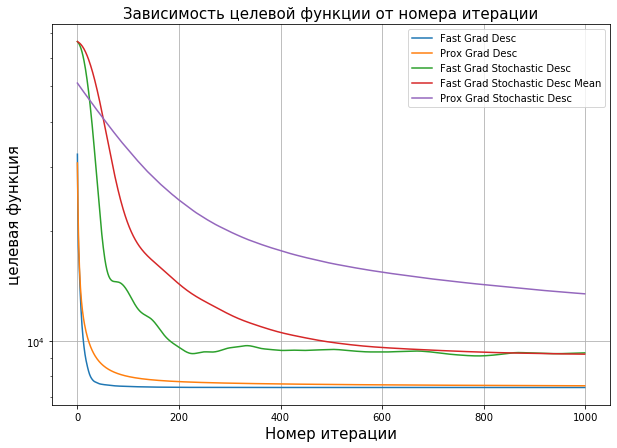

In [275]:
niter = np.arange(len(fs_prox))
plt.figure(figsize=(10, 7))
plt.semilogy(niter, fs_fast, label="Fast Grad Desc")
plt.semilogy(niter, fs_prox, label="Prox Grad Desc")
plt.semilogy(niter, fs_fast_stoch, label="Fast Grad Stochastic Desc")
plt.semilogy(niter, fs_fast_stoch_mean, label="Fast Grad Stochastic Desc Mean")
plt.semilogy(niter, fs_prox_stoch, label="Prox Grad Stochastic Desc")
plt.grid()
plt.title("Зависимость целевой функции от номера итерации", fontsize=15)
plt.xlabel("Номер итерации", fontsize=15)
plt.ylabel("целевая функция", fontsize=15)
plt.legend()
None

Выше представлены графики зависимости значения целевой функции от номера итераций для быстрого град. спуска, проксимального градиента и их стохастических аналогов. Видно, что нестохастические методы достаточно быстро сходятся к плато. Стохастические же методы делают это долго, видно, что проксимальный градиент даже не успел сойтись. Быстрый стох. градиент сходится относительно быстро(200 итераций). Стоить, однако, отметить, что в стохастических методах я аппроксимировал градиент по 1000 слагаемым из суммы ( всего их 22000), и каждая итерация проделывалась значительно быстрее. Этого, однако, не видно в коде выше, так как на каждой итерации стохастических методов я вычислял исходную целевую функцию, чтобы можно было сравнивать графики(это занимает большую часть времени работы этих методов). Если же это убрать, то стохастические методы будут примерно в 25 раз быстрее (по времени, затраченному на одну итерацию).

На графике выше зеленым изображен быстрый стохастический град. спуск, а красным -- он же, только целевая функция оценивалась на среднем значении всех предыдущих $w$. Видно, что график сходится к плато чуть медленее, однако более плавно и монотонно. 